In [1]:
import pandas as pd
import json

json_data = [json.loads(line) for line in open("experiments/results/test/search_results.jsonl")]
print(f"Got {len(json_data)} records")

Got 100 records


In [2]:
from rank_fuser import RankFuser

rf = RankFuser(
    config={
        "recency": 0.05,
        "log_citations": 0.05,
        "roberta_nli": 0.9
    }
)
print([metric.name for metric in rf.metrics])
print(rf.weights)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/nli-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['recency', 'log_citations', 'roberta_nli']
[0.05, 0.05, 0.9]


In [3]:
json_data[0]['results'][0]

{'pubdate': 20061001,
 'citation_count': 197,
 'text': 'On a larger scale Phillips et al. ( 1996 ) and Matthews Gallagher ( 1997 ) surveyed the nuclei of nearby spirals and found NCs in 6 out of 10 and in 10 out of 49 late‐type spirals, respectively (see also Matthews et al. 1999 ). Subsequently, Carollo et al. ( 1997 , 1998 ) found nuclear pointlike sources to be present in many of the nearby spiral galaxies in their sample. Farther down the Hubble sequence exist such examples as the bright, central cluster in NGC 1705 (Ho Filippenko 1996 ), a dwarf irregular galaxy. Active galaxies are also observed to host NCs in some cases (e.g., Thatte et al. 1997 ; Gallimore Matthews 2003 ; Schinnerer et al. 2001 ). In the specific case of late‐type spirals, Böker et al. ( 2002 , hereafter B02 ) found that NCs are present in ≈75% of the galaxies. Although these clusters are almost ubiquitous at least in spiral galaxies, their properties have not been extensively studied. Indeed, for all galaxies 

In [4]:
reranked_df = rf.rerank(json_data)

Reranking results: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


In [5]:
print(type(reranked_df[0]))
print(type(reranked_df[0]["results"]))
print(reranked_df[0]["results"])

<class 'dict'>
<class 'pandas.core.frame.DataFrame'>
     pubdate  citation_count  \
0   20061001             197   
1   20001001             888   
2   20030201             909   
3   20030201             909   
4   19970301             862   
5   19800701            1411   
6   19991101             609   
7   19881001             494   
8   19950101             236   
9   19831101             408   
10  20050801             132   
11  19950601             244   
12  20020901             119   
13  19980901             130   
14  19831101             408   
15  19661101             732   
16  20020901             119   
17  19931001              91   
18  19881001              78   
19  19960401              57   

                                                 text  \
0   On a larger scale Phillips et al. ( 1996 ) and...   
1   Two events for which we have an HST image (eve...   
2   Figure 2 shows NGC 253 as seen in the near‐inf...   
3   Note that the 2MASS images may not be sens

In [6]:
from statistics_computation import compute_statistics, stat_diffs

old_stats = compute_statistics(json_data)
for key, value in old_stats.items():
    print(f"{key}: {value[:10]}")

new_stats = compute_statistics(reranked_df)
for key, value in new_stats.items():
    print(f"{key}: {value[:10]}")

Computing statistics: 100%|██████████| 100/100 [00:00<00:00, 2701.98it/s]


hitrate: [0.2  0.31 0.35 0.37 0.41 0.42 0.45 0.47 0.47 0.5 ]
iou: [0.16083333 0.167      0.15583333 0.1445     0.14169048 0.13761905
 0.13634524 0.12967857 0.12664683 0.12249603]
recall: [0.16083333 0.26083333 0.30083333 0.32666667 0.36       0.3775
 0.4075     0.4275     0.4325     0.4575    ]


Computing statistics: 100%|██████████| 100/100 [00:00<00:00, 3267.99it/s]

hitrate: [0.07 0.17 0.19 0.23 0.3  0.33 0.36 0.37 0.39 0.41]
iou: [0.05833333 0.10583333 0.09366667 0.09366667 0.10359524 0.09986905
 0.10563492 0.0989246  0.09527381 0.09462734]
recall: [0.05833333 0.14166667 0.16333333 0.20333333 0.27166667 0.28416667
 0.31916667 0.32416667 0.33916667 0.36166667]


In [7]:
diffs = stat_diffs(old_stats, new_stats)

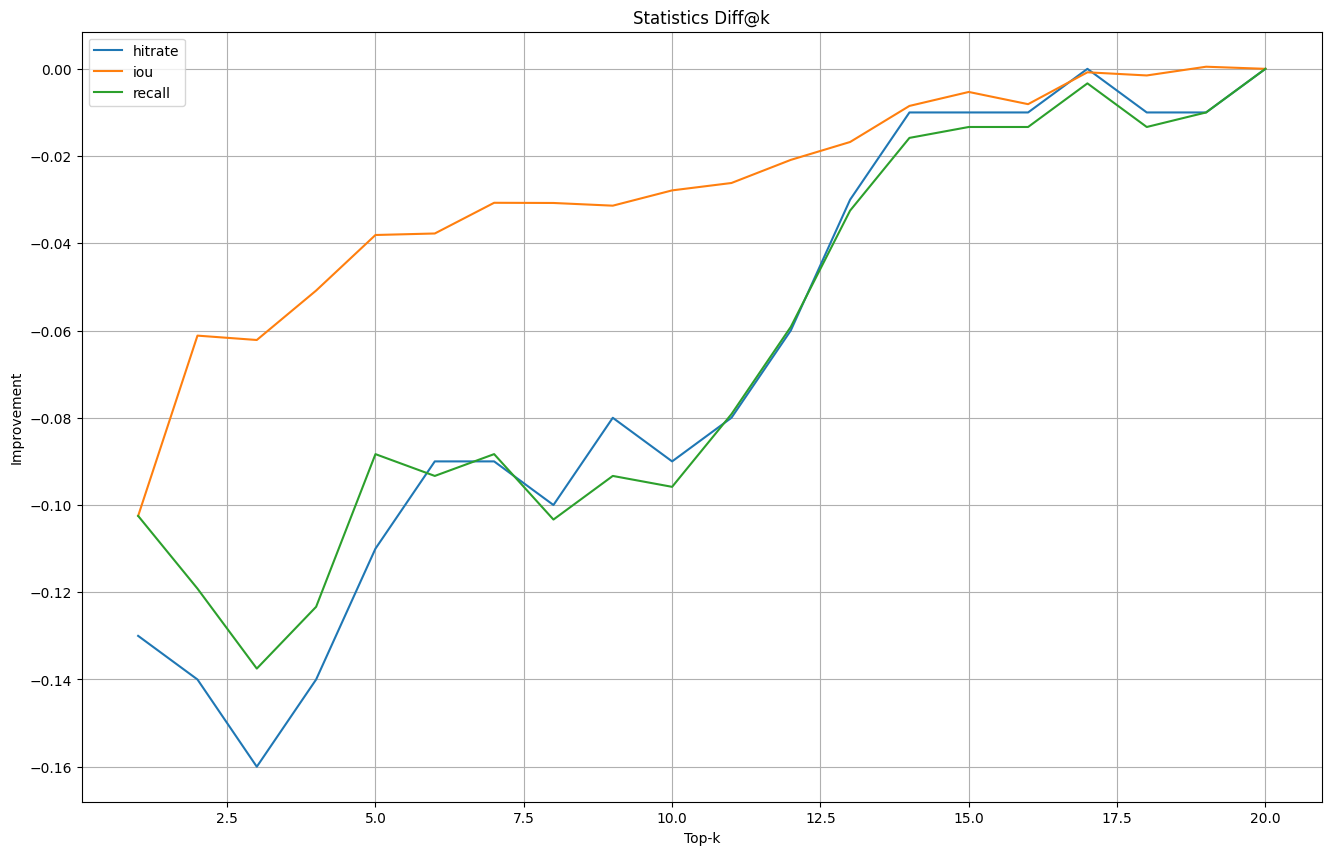

In [8]:
import matplotlib.pyplot as plt

# plot the diffs arrays hitrate, iou, and recall on the same plot
plt.figure(figsize=(16, 10))
# NOTE: this assumes all arrays have same length, came from same top k and k were in fact retrieved
k_values = [k for k in range(1, len(diffs["hitrate"]) + 1)]

lines = []
for label, values in diffs.items():
    (line, ) = plt.plot(k_values, values, label=label)
plt.title("Statistics Diff@k")
plt.xlabel("Top-k")
plt.ylabel("Improvement")
plt.legend()
plt.grid()
plt.show()